In [1]:
import torch
import numpy as np
import einops
import matplotlib.pyplot as plt

from tqdm import tqdm

import cfollmer.functional as functional
from cfollmer.objectives import relative_entropy_control_cost
from cfollmer.drifts import SimpleForwardNetBN
from cfollmer.sampler_utils import FollmerSDE

from functools import partial

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def log_p(mus, sigma2, x):
    # x : [b, 2]
    # mus : [n, 2]
    
    # I need x - mus : [b, n,]
    dist_to_means = torch.cdist(x, mus)**2
    return torch.logsumexp(-dist_to_means / (2 * sigma2), 1)

In [4]:
def plot_distribution(mus, sigma2, ax):
    rng = torch.linspace(-5, 5, 100, device=device)
    xx, yy = torch.meshgrid(rng, rng)
    coords = torch.dstack([xx, yy])
    coords = coords.reshape(-1, 2)
    log_ps = log_p(mus, sigma2, coords)
    z = log_ps.reshape(100, 100)
    z = torch.exp(z)
    ax.contourf(xx.cpu(), yy.cpu(), z.cpu(), levels=50)

In [7]:
d = 1.0
sigma2 = 0.05
mus_full = torch.tensor([
    [- d, 0.0],
    [- d, d],
    [- d, -d],
    [- d, 2 * d],
    [- d, - 2 * d],
    [- 4 * d, 0.0],
    [- 4 * d, d],
    [- 4 * d, -d],
    [- 4 * d, 2 * d],
    [- 4 * d, - 2 * d],
    [d, 0.0],
    [d, d],
    [d, -d],
    [d, 2 * d],
    [d, - 2 * d],
    [4 * d, 0.0],
    [4 * d, d],
    [4 * d, -d],
    [4 * d, 2 * d],
    [4 * d, - 2 * d],
], device=device)

mus_farthest = torch.tensor([
    [- 4 * d, 0.0],
    [- 4 * d, d],
    [- 4 * d, -d],
    [- 4 * d, 2 * d],
    [- 4 * d, - 2 * d],
    [4 * d, 0.0],
    [4 * d, d],
    [4 * d, -d],
    [4 * d, 2 * d],
    [4 * d, - 2 * d],
], device=device)

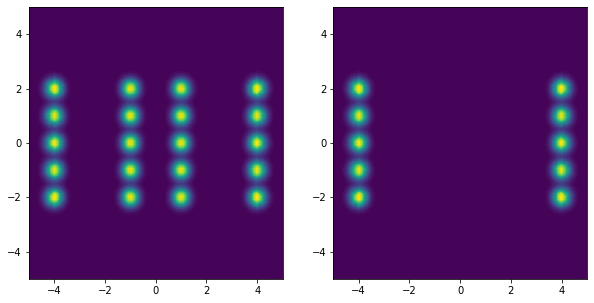

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plot_distribution(mus_full, sigma2, axes[0])
plot_distribution(mus_farthest, sigma2, axes[1])

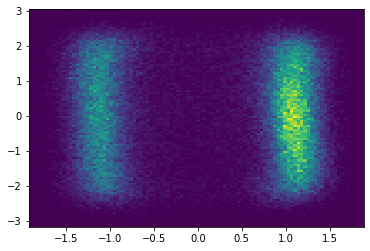

In [15]:
plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

In [9]:
def train(gamma, n_iterations, param_batch_size, log_p, dt=0.05):
    
    sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=2, width=300)).to(device)
    optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
    
    losses = []
    
    for _ in tqdm(range(n_iterations)):
        optimizer.zero_grad()
        
        loss = relative_entropy_control_cost(sde, log_p, param_batch_size=param_batch_size, dt=dt, device=device)
        loss.backward()
        
        optimizer.step()
        losses.append(loss.detach().cpu().numpy())
    
    losses = np.array(losses)
    
    return sde, losses

In [12]:
gamma = 0.1
n_iterations = 2000
param_batch_size = 128

In [13]:
log_p_full = partial(log_p, mus_full, sigma2)
sde, losses = train(gamma, n_iterations, param_batch_size, log_p_full, dt=0.05)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [01:14<00:00, 26.86it/s]


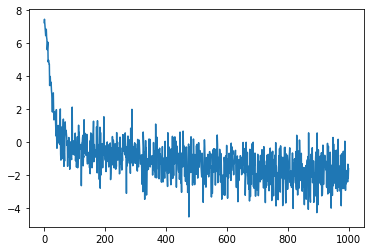

In [73]:
plt.plot(losses)

In [14]:
with torch.no_grad():
    samples = sde.sample(100000, dt=0.01, device=device)
    samples = samples.cpu().numpy()

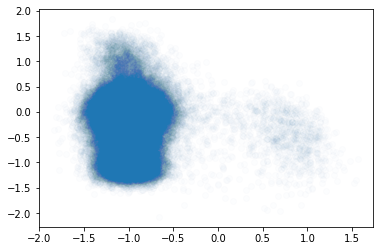

In [75]:
plt.scatter(samples[:, 0], samples[:, 1], alpha=0.01)

In [51]:
log_p_full = partial(log_p, mus_farthest, sigma2)
sde, losses = train(gamma, 10000, param_batch_size, log_p_full, dt=0.05)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [05:16<00:00, 31.63it/s]


In [52]:
with torch.no_grad():
    samples = sde.sample(100000, dt=0.01, device=device)
    samples = samples.cpu().numpy()

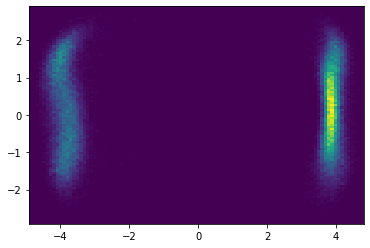

In [54]:
plt.hist2d(samples[:, 0], samples[:, 1], bins=100);

In [356]:
sde = FollmerSDE(gamma, SimpleForwardNetBN(input_dim=2, width=300)).to(device)
optimizer = torch.optim.Adam(sde.parameters(), lr=1e-4)
dt = 0.05

(-5.0, 5.0)

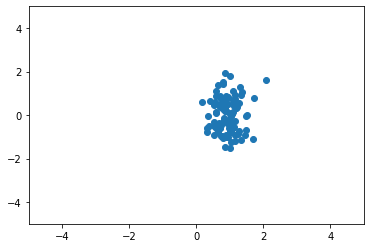

In [403]:
optimizer.zero_grad()
        
loss = relative_entropy_control_cost(sde, log_p, param_batch_size=param_batch_size, dt=dt, device=device)
loss.backward()

optimizer.step()

with torch.no_grad():
    samples = sde.sample(100, dt=0.01, device=device)
    samples = samples.cpu().numpy()
    
plt.scatter(samples[:, 0], samples[:, 1])
plt.xlim(-5, 5)
plt.ylim(-5, 5)